# validation.ipynb
Scratch notebook to check the outputs of Go Big forward models

In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from os.path import join as pjoin


import astropy
from astropy.io import fits
import pandas as pd
# import nbodykit.lab as nblab
# from nbodykit import cosmology

# cosmo = cosmology.Cosmology()

# from tools.BOSS_FM import BOSS_angular, BOSS_veto, BOSS_redshift, thetahod_literature

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
lhid = 0
wdir = '../data'
source_dir = pjoin(wdir, 'pmwd/L3000-N384', str(lhid))

lhpath = pjoin(wdir, 'quijote', 'latin_hypercube_params_bonus.txt')
lh_lookup = pd.read_csv(
    lhpath, delimiter=' ', header=None, 
    names=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8'])
print(lh_lookup.iloc[lhid+1])

Omega_m    0.21390
Omega_b    0.05557
h          0.85990
n_s        0.97850
sigma_8    0.86190
Name: 1, dtype: float64


In [ ]:
def SkytoCartesian(ra, dec, z):
    

## simulation/rho_to_halo.py

In [5]:
Lbox=3000
rho = np.load(pjoin(source_dir, 'rho.npy'))
hpos = np.load(pjoin(source_dir, 'halo_pos.npy'))
hmass = np.load(pjoin(source_dir, 'halo_mass.npy'))
hcpos = np.load(pjoin(source_dir, 'halo_cuboid_pos.npy'))

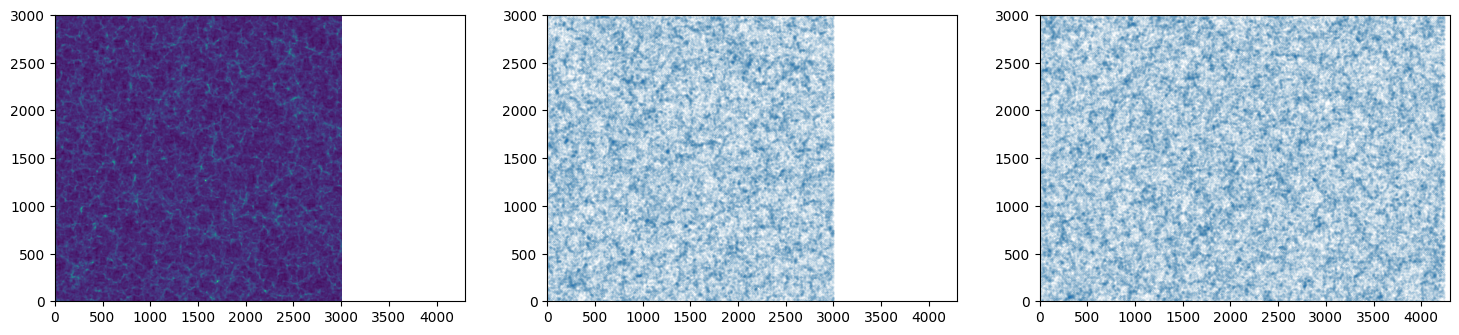

In [6]:
# plot slice
fig, axs = plt.subplots(1,3, figsize=(18,6))

axs[0].imshow(np.mean(rho[:,:,:13], axis=-1), 
              extent=[0, Lbox, 0, Lbox],
              origin='lower')
axs[0].set_xlim(0, 4.3*1e3)
axs[0].set_ylim(0, Lbox)
axs[0].set_aspect('equal')

mask = (hpos[:, -1] > 0) & (hpos[:, -1] < 100)
axs[1].scatter(hpos[mask, 0], hpos[mask, 1], s=0.1, alpha=0.1)
axs[1].set_xlim(0, 4.3*1e3)
axs[1].set_ylim(0, Lbox)
axs[1].set_aspect('equal')

mask = (hcpos[:, -1] > 0) & (hcpos[:, -1] < 100)
axs[2].scatter(hcpos[mask, 0], hcpos[mask, 1], s=0.1, alpha=0.1)
axs[2].set_xlim(0, 4.3*1e3)
axs[2].set_ylim(0, Lbox)
axs[2].set_aspect('equal')

3341294

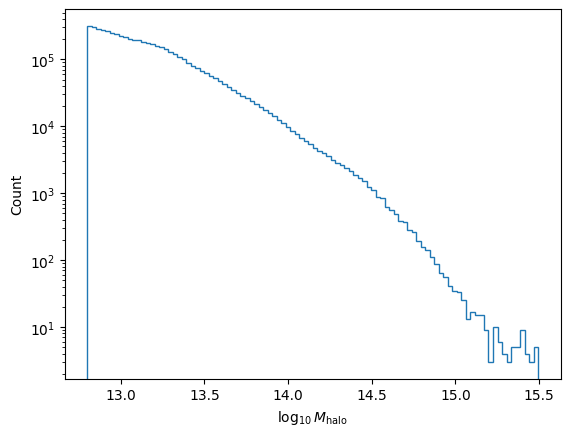

In [7]:
plt.semilogy()
plt.hist((hmass), bins=100, histtype='step')
plt.xlabel(r'$\log_{10}M_{\rm halo}$')
plt.ylabel('Count')

np.sum(hmass > 13)

## simulation/apply_hod.py

In [8]:
seed = 0
hod = np.load(pjoin(source_dir, 'hod', f'hod{seed}_pos.npy'))

FileNotFoundError: [Errno 2] No such file or directory: '../data/pmwd/L3000-N384/0/hod/hod0_pos.npy'

Text(0.5, 1.0, 'HOD')

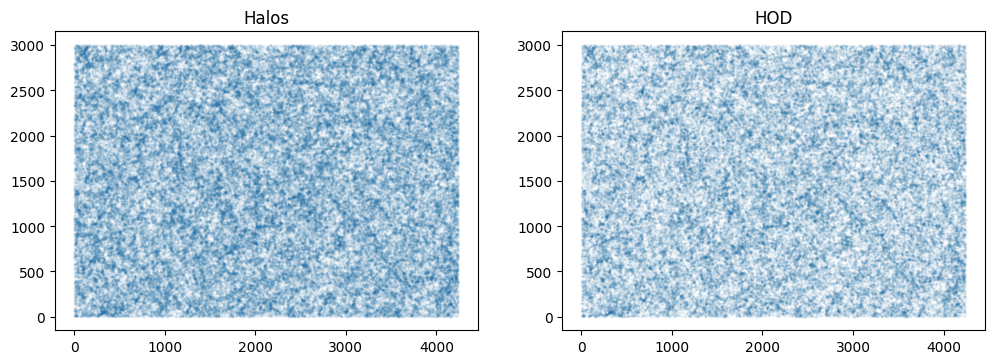

In [10]:
# plot hod comparison
fig, axs = plt.subplots(1,2, figsize=(12,6))

mask = (hcpos[:, -1] > 0) & (hcpos[:, -1] < 100)
axs[0].scatter(hcpos[mask, 0], hcpos[mask, 1], s=0.1, alpha=0.1)
axs[0].set_aspect('equal')
axs[0].set_title('Halos')

mask = (hod[:, -1] > 0) & (hod[:, -1] < 100)
axs[1].scatter(hod[mask, 0], hod[mask, 1], s=0.1, alpha=0.1)
axs[1].set_aspect('equal')
axs[1].set_title('HOD')

## simulation/apply_survey.py


In [11]:
# load simulation
rdz = np.load(pjoin(source_dir, 'obs', f'rdz{seed}.npy'))
pos = np.array(nblab.transform.SkyToCartesian(*rdz.T, cosmo=cosmo))

NameError: name 'nblab' is not defined

In [78]:
# load survey
def load_galaxies(fname, fields):
    with fits.open(fname) as hdul:
        gals = np.array([hdul[1].data[x] for x in fields]).T
        gals = pd.DataFrame(gals, columns=fields)    
    return gals
# load data
fname = 'data/obs/galaxy_DR12v5_CMASSLOWZTOT_North.fits'
fields = ['RA','DEC','Z',
          'WEIGHT_SYSTOT','WEIGHT_NOZ','WEIGHT_CP']
cmass = load_galaxies(fname, fields)
mask = BOSS_angular(cmass['RA'], cmass['DEC'])
mask *= BOSS_redshift(cmass['Z'])
cmass = cmass[mask].reset_index(drop=True)

crdz = np.stack([cmass['RA'], cmass['DEC'], cmass['Z']], axis=-1)
cpos = nblab.transform.SkyToCartesian(*crdz.T, cosmo=cosmo)
cpos = np.array(cpos.compute())

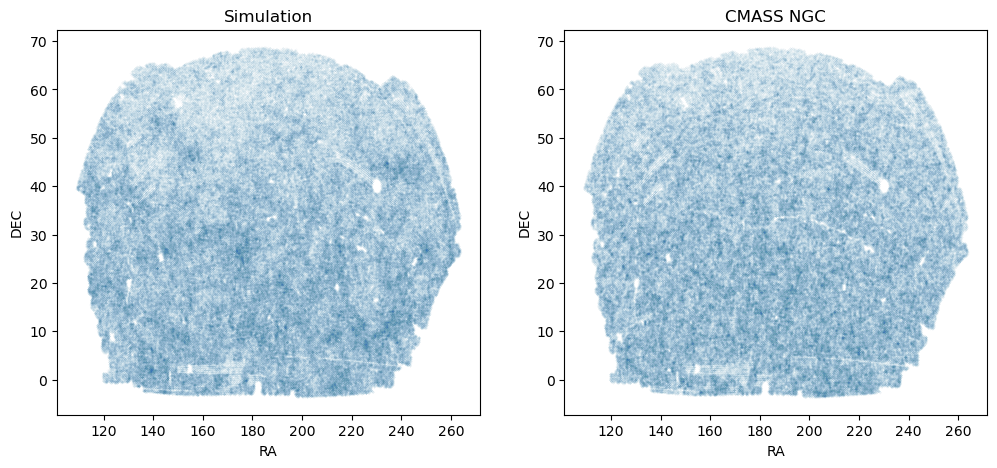

In [79]:
# plot sky-projection
fig, axs = plt.subplots(1,2, figsize=(12,5))

axs[0].scatter(rdz[:, 0], rdz[:, 1], s=0.05, alpha=0.05)
axs[0].set_title('Simulation')
axs[0].set_xlabel('RA')
axs[0].set_ylabel('DEC')

axs[1].scatter(crdz[:, 0], crdz[:, 1], s=0.05, alpha=0.05)
axs[1].set_title('CMASS NGC')
axs[1].set_xlabel('RA')
axs[1].set_ylabel('DEC')
fig.savefig('images/rdz.jpg', dpi=300, bbox_inches='tight')

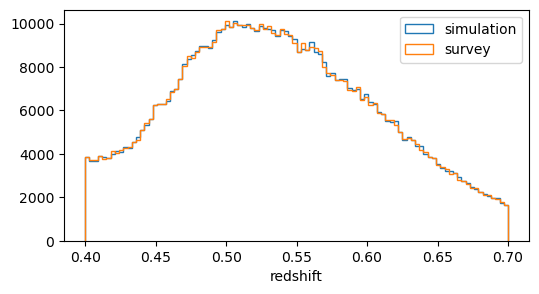

In [67]:
# plot redshift distribution on top of each other
fig, axs = plt.subplots(1,1, figsize=(6,3))

axs.hist(rdz[:, 2], bins=100, histtype='step', label='simulation')
axs.hist(crdz[:, 2], bins=100, histtype='step', label='survey')
axs.set_xlabel('redshift')
axs.legend()

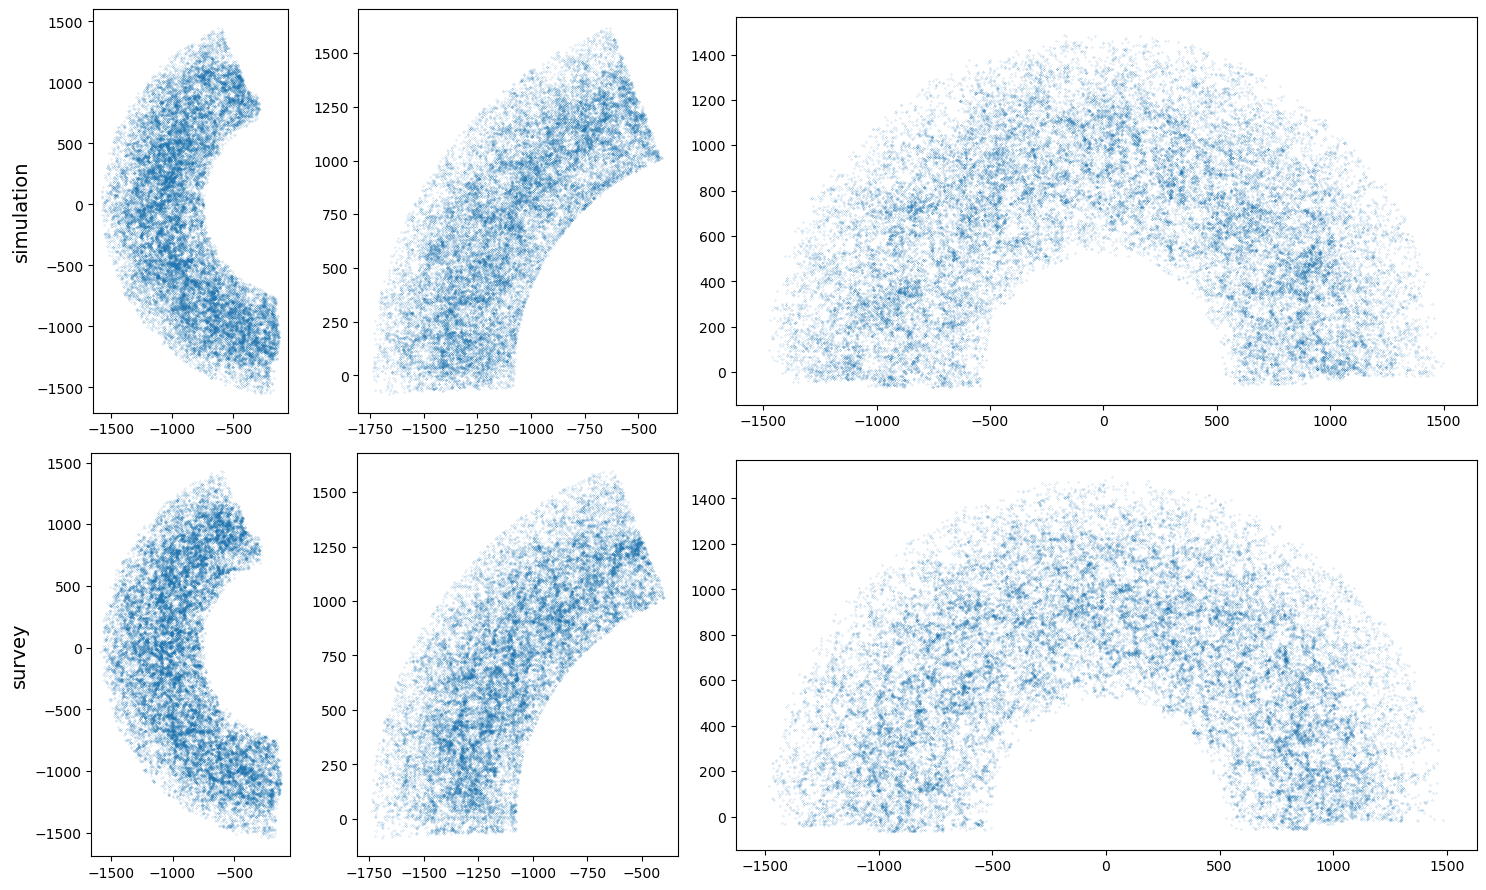

In [257]:
def slice_mask(x):
    mima = x.min(), x.max()
    dx = (mima[1] - mima[0])*0.02
    mid = np.mean(mima)
    return (x > mid - dx) & (x < mid + dx)

# plot cpos from all axes
fig, axs = plt.subplots(2,3, figsize=(18,11), gridspec_kw={'width_ratios':[1,2,3.4], 'hspace':0.1, 'wspace':0.})

for i, ipos in enumerate([pos, cpos]):
    mask = slice_mask(ipos[:, 2])
    axs[i,0].scatter(ipos[mask, 0], ipos[mask, 1], s=0.01, alpha=1)
    axs[i,0].set_aspect('equal')

    mask = slice_mask(ipos[:, 1])
    axs[i,1].scatter(ipos[mask, 0], ipos[mask, 2], s=0.01, alpha=1)
    axs[i,1].set_aspect('equal')

    mask = slice_mask(ipos[:, 0])
    axs[i,2].scatter(ipos[mask, 1], ipos[mask, 2], s=0.01, alpha=1)
    axs[i,2].set_aspect('equal')

    if i==0:
        axs[i,0].set_ylabel('simulation', fontsize=14)
    else:
        axs[i,0].set_ylabel('survey',   fontsize=14)

fig.savefig('images/pos_comparison.jpg', dpi=180, bbox_inches='tight')

In [234]:
from scipy.spatial.transform import Rotation as R
r = R.from_quat([0, 0, np.sin(np.pi/4), np.cos(np.pi/4)]).as_matrix()
hcposR = hcpos@r
hcposR -= (hcposR.max(axis=0) + hcposR.min(axis=0))/2
hcposR += [-924.42673929,  -44.04583784,  750.98510587]

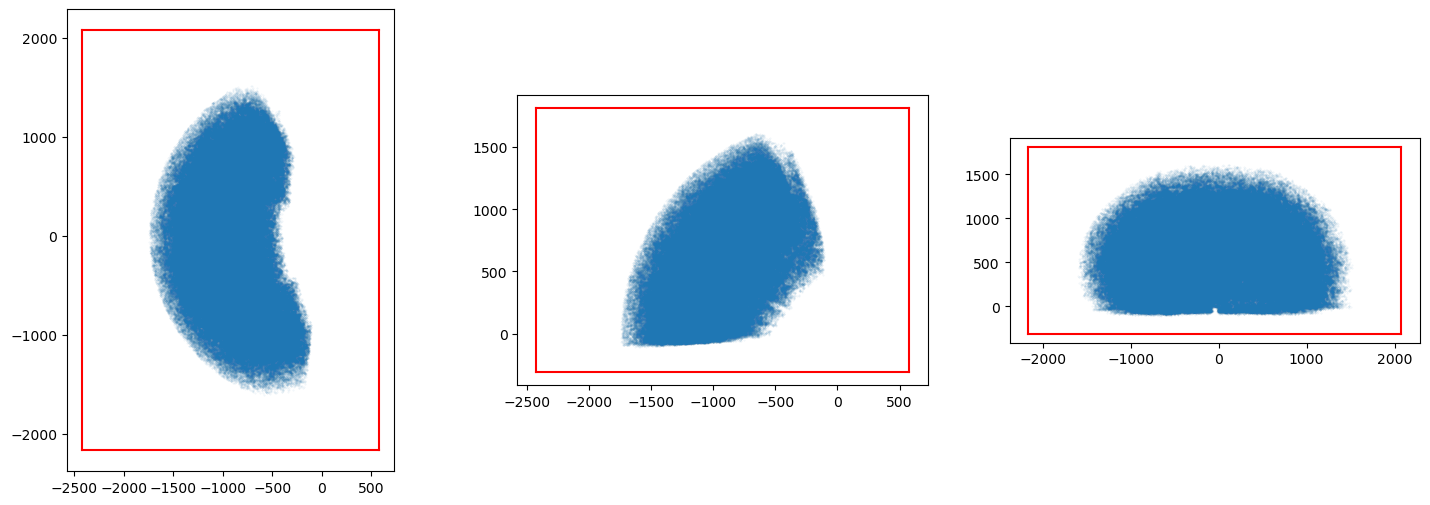

In [235]:
# plot positions from each axis
mins, maxs = hcposR.min(axis=0), hcposR.max(axis=0)
def plot_rectangle(min_x, min_y, max_x, max_y, ax, c='r'):
    ax.plot([min_x, min_x], [min_y, max_y], c=c)
    ax.plot([min_x, max_x], [min_y, min_y], c=c)
    ax.plot([max_x, max_x], [min_y, max_y], c=c)
    ax.plot([min_x, max_x], [max_y, max_y], c=c)

fig, axs = plt.subplots(1,3, figsize=(18,6))

axs[0].scatter(cpos[:, 0], cpos[:, 1], s=0.1, alpha=0.1)
plot_rectangle(mins[0], mins[1], maxs[0], maxs[1], axs[0])
axs[0].set_aspect('equal')

axs[1].scatter(cpos[:, 0], cpos[:, 2], s=0.1, alpha=0.1)
plot_rectangle(mins[0], mins[2], maxs[0], maxs[2], axs[1])
axs[1].set_aspect('equal')

axs[2].scatter(cpos[:, 1], cpos[:, 2], s=0.1, alpha=0.1)
plot_rectangle(mins[1], mins[2], maxs[1], maxs[2], axs[2])
axs[2].set_aspect('equal')

## summaries/calc_Pk_nbkit.py

In [56]:
# load simulation Pk
simtype = ['pmwd']
# lhid=499
seed = 3

Pkdict = {}
for j in simtype:
    source_dir = pjoin(
            '../data', f'{j}/L3000-N384',
            f'{lhid}', 'Pk')
    outpath = pjoin(source_dir, f'Pk{seed}.npz')
    out = np.load(outpath)
    k_sim, p0k_sim, p2k_sim, p4k_sim = out['k_gal'], out['p0k_gal'], out['p2k_gal'], out['p4k_gal']
    Pkdict[j] = k_sim, p0k_sim, p2k_sim, p4k_sim

# load survey Pk
source_dir = '../data/obs'
outpath = pjoin(source_dir, 'Pk', 'Pk.npz')
out = np.load(outpath)
k_sur, p0k_sur, p2k_sur, p4k_sur = out['k_gal'], out['p0k_gal'], out['p2k_gal'], out['p4k_gal']

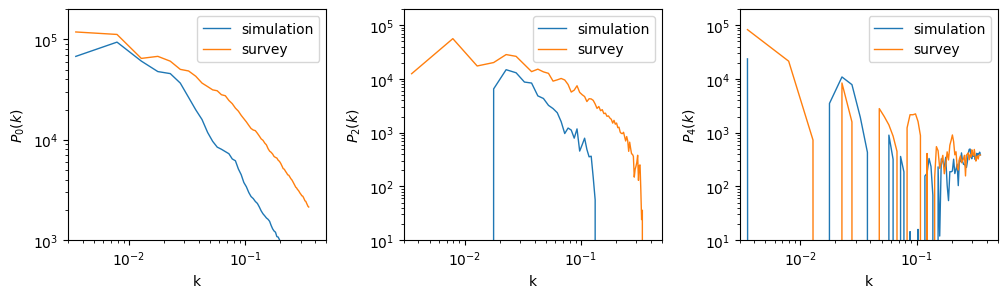

In [57]:
k_sim, p0k_sim, p2k_sim, p4k_sim = Pkdict['pmwd']

# plot simulation and survey Pk for a best-fit HOD model
fig, axs = plt.subplots(1,3, figsize=(12,3),
                        gridspec_kw={'wspace':0.3})

axs[0].plot(k_sim, p0k_sim, label='simulation', lw=1)
axs[0].plot(k_sur, p0k_sur, label='survey', lw=1)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('k')
axs[0].set_ylabel('$P_0(k)$')
axs[0].set_xlim(3e-3, 5e-1)
axs[0].set_ylim(1e3, 2*1e5)
axs[0].legend()

axs[1].plot(k_sim, p2k_sim, label='simulation', lw=1)
axs[1].plot(k_sur, p2k_sur, label='survey', lw=1)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('k')
axs[1].set_ylabel('$P_2(k)$')
axs[1].set_xlim(3e-3, 5e-1)
axs[1].set_ylim(1e1, 2*1e5)
axs[1].legend()

axs[2].plot(k_sim, p4k_sim, label='simulation', lw=1)
axs[2].plot(k_sur, p4k_sur, label='survey', lw=1)
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel('k')
axs[2].set_ylabel('$P_4(k)$')
axs[2].set_xlim(3e-3, 5e-1)
axs[2].set_ylim(1e1, 2*1e5)
axs[2].legend()

# fig.savefig('../images/Pk_comparison.jpg', dpi=180, bbox_inches='tight')

In [84]:
# load simulation Pk
simtype = ['borg', 'jaxlpt', 'pmwd']
seed = 0

Pkdict = {}
for j in simtype:
    source_dir = pjoin(
            './data', f'{j}-quijote/latin_hypercube_HR-L3000-N384',
            f'{lhid}', 'Pk')
    outpath = pjoin(source_dir, f'Pk{seed}.npz')
    out = np.load(outpath)
    k_sim, p0k_sim, p2k_sim, p4k_sim = out['k_gal'], out['p0k_gal'], out['p2k_gal'], out['p4k_gal']
    Pkdict[j] = k_sim, p0k_sim, p2k_sim, p4k_sim

# load survey Pk
source_dir = 'data/obs'
outpath = pjoin(source_dir, 'Pk', 'Pk.npz')
out = np.load(outpath)
k_sur, p0k_sur, p2k_sur, p4k_sur = out['k_gal'], out['p0k_gal'], out['p2k_gal'], out['p4k_gal']

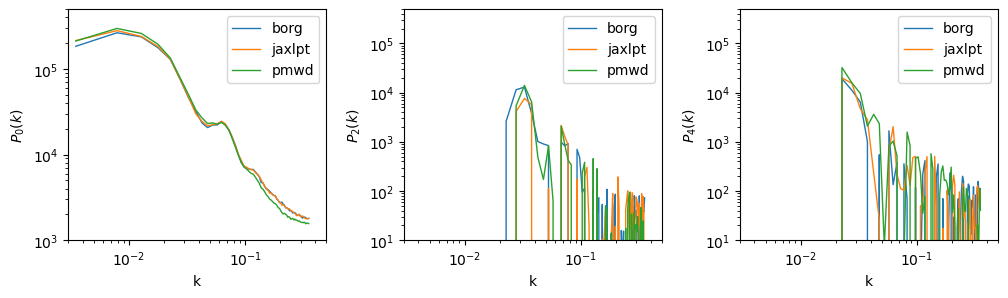

In [88]:
# plot simulation and survey Pk for a best-fit HOD model
fig, axs = plt.subplots(1,3, figsize=(12,3),
                        gridspec_kw={'wspace':0.3})


for j in simtype:
    k_sim, p0k_sim, p2k_sim, p4k_sim = Pkdict[j]
    axs[0].plot(k_sim, p0k_sim, label=j, lw=1)
    axs[1].plot(k_sim, p2k_sim, label=j, lw=1)
    axs[2].plot(k_sim, p4k_sim, label=j, lw=1)

# axs[0].plot(k_sur, p0k_sur, label='survey', lw=1)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('k')
axs[0].set_ylabel('$P_0(k)$')
axs[0].set_xlim(3e-3, 5e-1)
axs[0].set_ylim(1e3, 5*1e5)
axs[0].legend()

# axs[1].plot(k_sur, p2k_sur, label='survey', lw=1)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('k')
axs[1].set_ylabel('$P_2(k)$')
axs[1].set_xlim(3e-3, 5e-1)
axs[1].set_ylim(1e1, 5*1e5)
axs[1].legend()

# axs[2].plot(k_sur, p4k_sur, label='survey', lw=1)
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel('k')
axs[2].set_ylabel('$P_4(k)$')
axs[2].set_xlim(3e-3, 5e-1)
axs[2].set_ylim(1e1, 5*1e5)
axs[2].legend()

fig.savefig('images/Pk_comparison.jpg', dpi=180, bbox_inches='tight')

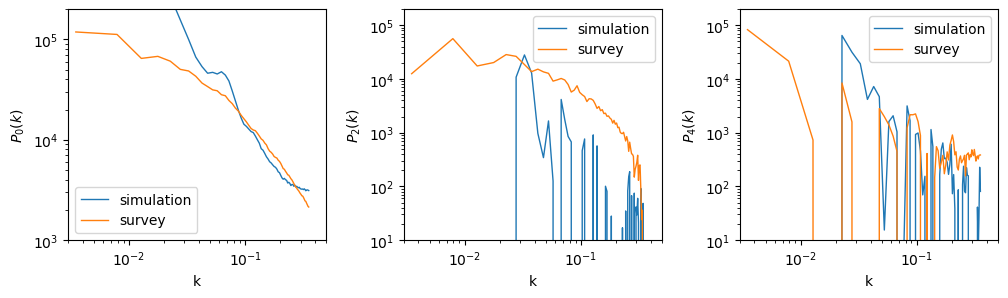

In [83]:
# plot simulation and survey Pk for a best-fit HOD model
fig, axs = plt.subplots(1,3, figsize=(12,3),
                        gridspec_kw={'wspace':0.3})

axs[0].plot(k_sim, p0k_sim*2, label='simulation', lw=1)
axs[0].plot(k_sur, p0k_sur, label='survey', lw=1)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('k')
axs[0].set_ylabel('$P_0(k)$')
axs[0].set_xlim(3e-3, 5e-1)
axs[0].set_ylim(1e3, 2*1e5)
axs[0].legend()

axs[1].plot(k_sim, p2k_sim*2, label='simulation', lw=1)
axs[1].plot(k_sur, p2k_sur, label='survey', lw=1)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('k')
axs[1].set_ylabel('$P_2(k)$')
axs[1].set_xlim(3e-3, 5e-1)
axs[1].set_ylim(1e1, 2*1e5)
axs[1].legend()

axs[2].plot(k_sim, p4k_sim*2, label='simulation', lw=1)
axs[2].plot(k_sur, p4k_sur, label='survey', lw=1)
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel('k')
axs[2].set_ylabel('$P_4(k)$')
axs[2].set_xlim(3e-3, 5e-1)
axs[2].set_ylim(1e1, 2*1e5)
axs[2].legend()

fig.savefig('images/Pk_comparison.jpg', dpi=180, bbox_inches='tight')

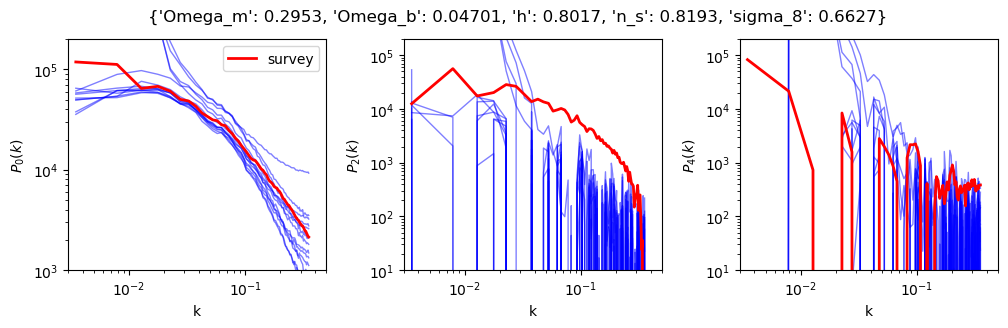

In [245]:
# plot simulation and survey Pk for various HOD models
fig, axs = plt.subplots(1,3, figsize=(12,3),
                        gridspec_kw={'wspace':0.3})


# load simulation Pk for seed in [0,50]
source_dir = pjoin(
        './data', 'borg-quijote/latin_hypercube_HR-L3000-N384',
        f'{lhid}', 'Pk')
for s in range(13): # range(40,100): # 
    outpath = pjoin(source_dir, f'Pk{s}.npz')
    out = np.load(outpath)
    k_sim, p0k_sim, p2k_sim, p4k_sim = out['k_gal'], out['p0k_gal'], out['p2k_gal'], out['p4k_gal']
    axs[0].plot(k_sim, p0k_sim*2, c='b', lw=1, alpha=0.5)
    axs[1].plot(k_sim, p2k_sim*2, c='b', lw=1, alpha=0.5)
    axs[2].plot(k_sim, p4k_sim*2, c='b', lw=1, alpha=0.5)


# axs[0].plot(k_sim, p0k_sim, label='simulation', lw=1)
axs[0].plot(k_sur, p0k_sur, label='survey', lw=2, c='r')
axs[0].loglog()
axs[0].set_xlabel('k')
axs[0].set_ylabel('$P_0(k)$')
axs[0].set_xlim(3e-3, 5e-1)
axs[0].set_ylim(1e3, 2*1e5)
axs[0].legend()

# axs[1].plot(k_sim, p2k_sim, label='simulation', lw=1)
axs[1].plot(k_sur, p2k_sur, label='survey', lw=2, c='r')
axs[1].loglog()
axs[1].set_xlabel('k')
axs[1].set_ylabel('$P_2(k)$')
axs[1].set_xlim(3e-3, 5e-1)
axs[1].set_ylim(1e1, 2*1e5)
# axs[1].legend()

# axs[2].plot(k_sim, p4k_sim, label='simulation', lw=1)
axs[2].plot(k_sur, p4k_sur, label='survey', lw=2, c='r')
axs[2].loglog()
axs[2].set_xlabel('k')
axs[2].set_ylabel('$P_4(k)$')
axs[2].set_xlim(3e-3, 5e-1)
axs[2].set_ylim(1e1, 2*1e5)
# axs[2].legend()
fig.suptitle(str(dict(lh_lookup.iloc[lhid])))
fig.savefig('images/Pk_comparison_HOD0.jpg', dpi=180, bbox_inches='tight')

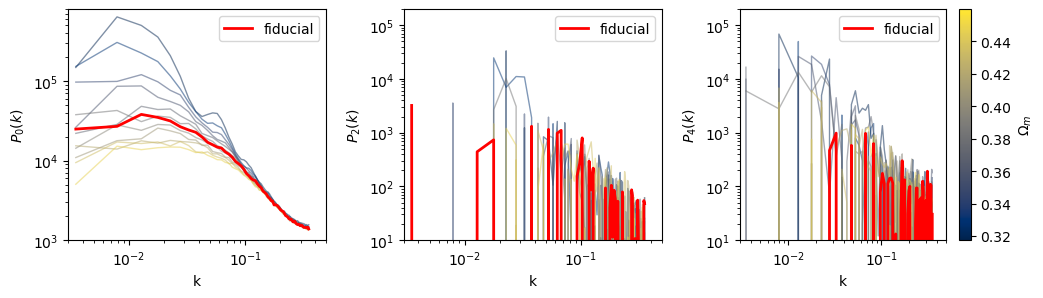

In [191]:
# plot simulation and survey Pk for different cosmologies
fig, axs = plt.subplots(1,3, figsize=(12,3),
                        gridspec_kw={'wspace':0.3})

cmap = mpl.colormaps.get_cmap('cividis')

# load simulation Pk for seed in [0,50]
lmin, lmax = 2000, 2011
for l in range(lmin, lmax):
    source_dir = pjoin(
            './data', 'borg-quijote/latin_hypercube_HR-L3000-N384',
            f'{l}', 'Pk')
    outpath = pjoin(source_dir, f'Pk0.npz')
    out = np.load(outpath)
    k_sim, p0k_sim, p2k_sim, p4k_sim = out['k_gal'], out['p0k_gal'], out['p2k_gal'], out['p4k_gal']
    color = cmap((l-lmin)/(lmax-lmin))
    axs[0].plot(k_sim, p0k_sim, c=color, lw=1, alpha=0.5)
    axs[1].plot(k_sim, p2k_sim, c=color, lw=1, alpha=0.5)
    axs[2].plot(k_sim, p4k_sim, c=color, lw=1, alpha=0.5)

l = 1999
source_dir = pjoin(
        './data', 'borg-quijote/latin_hypercube_HR-L3000-N384',
        f'{l}', 'Pk')
outpath = pjoin(source_dir, f'Pk0.npz')
out = np.load(outpath)
k_sim, p0k_sim, p2k_sim, p4k_sim = out['k_gal'], out['p0k_gal'], out['p2k_gal'], out['p4k_gal']
# axs[0].plot(k_sim, p0k_sim, label='simulation', lw=1)
axs[0].plot(k_sim, p0k_sim, label='fiducial', lw=2, c='r')
axs[0].loglog()
axs[0].set_xlabel('k')
axs[0].set_ylabel('$P_0(k)$')
axs[0].set_xlim(3e-3, 5e-1)
axs[0].set_ylim(1e3, 8*1e5)
axs[0].legend()

# axs[1].plot(k_sim, p2k_sim, label='simulation', lw=1)
axs[1].plot(k_sim, p2k_sim, label='fiducial', lw=2, c='r')
axs[1].loglog()
axs[1].set_xlabel('k')
axs[1].set_ylabel('$P_2(k)$')
axs[1].set_xlim(3e-3, 5e-1)
axs[1].set_ylim(1e1, 2*1e5)
axs[1].legend()

# axs[2].plot(k_sim, p4k_sim, label='simulation', lw=1)
axs[2].plot(k_sim, p4k_sim, label='fiducial', lw=2, c='r')
axs[2].loglog()
axs[2].set_xlabel('k')
axs[2].set_ylabel('$P_4(k)$')
axs[2].set_xlim(3e-3, 5e-1)
axs[2].set_ylim(1e1, 2*1e5)
axs[2].legend()

norm = mpl.colors.Normalize(vmin=lh_lookup.iloc[lmin,0], vmax=lh_lookup.iloc[lmax-1,0])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[2], label='$\Omega_m$')

fig.savefig('images/Pk_comparison_Om.jpg', dpi=180, bbox_inches='tight')

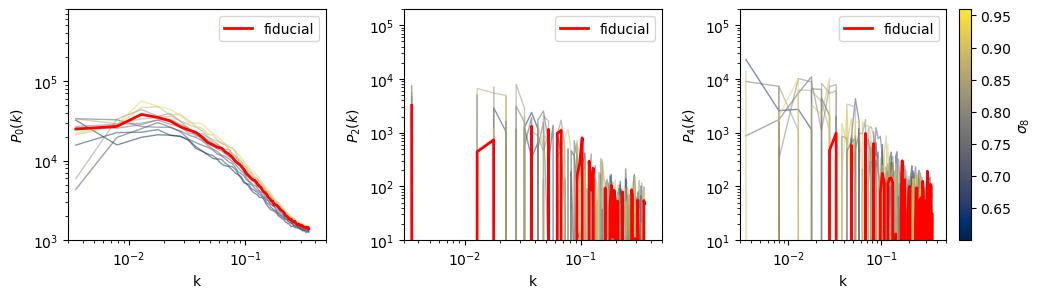

In [192]:
# plot simulation and survey Pk for different cosmologies
fig, axs = plt.subplots(1,3, figsize=(12,3),
                        gridspec_kw={'wspace':0.3})

cmap = mpl.colormaps.get_cmap('cividis')

# load simulation Pk for seed in [0,50]
lmin, lmax = 2012, 2022
for l in range(lmin, lmax):
    source_dir = pjoin(
            './data', 'borg-quijote/latin_hypercube_HR-L3000-N384',
            f'{l}', 'Pk')
    outpath = pjoin(source_dir, f'Pk0.npz')
    out = np.load(outpath)
    k_sim, p0k_sim, p2k_sim, p4k_sim = out['k_gal'], out['p0k_gal'], out['p2k_gal'], out['p4k_gal']
    color = cmap((l-lmin)/(lmax-lmin))
    axs[0].plot(k_sim, p0k_sim, c=color, lw=1, alpha=0.5)
    axs[1].plot(k_sim, p2k_sim, c=color, lw=1, alpha=0.5)
    axs[2].plot(k_sim, p4k_sim, c=color, lw=1, alpha=0.5)

l = 1999
source_dir = pjoin(
        './data', 'borg-quijote/latin_hypercube_HR-L3000-N384',
        f'{l}', 'Pk')
outpath = pjoin(source_dir, f'Pk0.npz')
out = np.load(outpath)
k_sim, p0k_sim, p2k_sim, p4k_sim = out['k_gal'], out['p0k_gal'], out['p2k_gal'], out['p4k_gal']
# axs[0].plot(k_sim, p0k_sim, label='simulation', lw=1)
axs[0].plot(k_sim, p0k_sim, label='fiducial', lw=2, c='r')
axs[0].loglog()
axs[0].set_xlabel('k')
axs[0].set_ylabel('$P_0(k)$')
axs[0].set_xlim(3e-3, 5e-1)
axs[0].set_ylim(1e3, 8*1e5)
axs[0].legend()

# axs[1].plot(k_sim, p2k_sim, label='simulation', lw=1)
axs[1].plot(k_sim, p2k_sim, label='fiducial', lw=2, c='r')
axs[1].loglog()
axs[1].set_xlabel('k')
axs[1].set_ylabel('$P_2(k)$')
axs[1].set_xlim(3e-3, 5e-1)
axs[1].set_ylim(1e1, 2*1e5)
axs[1].legend()

# axs[2].plot(k_sim, p4k_sim, label='simulation', lw=1)
axs[2].plot(k_sim, p4k_sim, label='fiducial', lw=2, c='r')
axs[2].loglog()
axs[2].set_xlabel('k')
axs[2].set_ylabel('$P_4(k)$')
axs[2].set_xlim(3e-3, 5e-1)
axs[2].set_ylim(1e1, 2*1e5)
axs[2].legend()

norm = mpl.colors.Normalize(vmin=lh_lookup.iloc[lmin,-1], vmax=lh_lookup.iloc[lmax-1,-1])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[2], label='$\sigma_8$')

fig.savefig('images/Pk_comparison_s8.jpg', dpi=180, bbox_inches='tight')

# Check different simulators

In [52]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'  # noqa, must go before jax

import numpy as np
import matplotlib.pyplot as plt
from os.path import join as pjoin
from collections import defaultdict

from pmwd import linear_power
from pmwd.spec_util import powspec
from pmwd.vis_util import simshow
from pmwd import (Configuration, Cosmology, boltzmann)

In [53]:
def configure_pmwd(L, N, N_steps, supersampling, ai, af, cosmo):
    ptcl_spacing = L/N
    ptcl_grid_shape = (N,)*3
    pmconf = Configuration(ptcl_spacing, ptcl_grid_shape,
                           a_start=ai, a_stop=af,
                           a_nbody_maxstep=(af-ai)/N_steps,
                           mesh_shape=supersampling)
    pmcosmo = Cosmology.from_sigma8(
        pmconf, sigma8=cosmo[4], n_s=cosmo[3], Omega_m=cosmo[0],
        Omega_b=cosmo[1], h=cosmo[2])
    pmcosmo = boltzmann(pmcosmo, pmconf)
    return pmconf, pmcosmo

def load_params(index, cosmofile):
    if index == "fid":
        return [0.3175, 0.049, 0.6711, 0.9624, 0.834]
    with open(cosmofile, 'r') as f:
        content = f.readlines()[index+1]
    content = [np.float64(x) for x in content.split()]
    return content

In [99]:
lhid = 3


cosmo = load_params(lhid, '/home/mattho/data/quijote/latin_hypercube_params.txt')
print(cosmo)
zi = 127           # initial redshift
zf = 0.55          # final redshift (default=CMASS)
ai = 1 / (1 + zi)  # initial scale factor
af = 1 / (1 + zf)  # final scale factor
pmconf, pmcosmo = configure_pmwd(3000, 384, 16, 1, ai, af, cosmo)

data = defaultdict(dict)
for i, n in enumerate(['borg2lpt', 'jax2lpt', 'pmwd']):
    path = f'../data/{n}/L3000-N384/{lhid}'
    print('Loading data from', path)
    data[n]['rho'] = np.load(pjoin(path, 'rho.npy'))
    data[n]['ppos'] = np.load(pjoin(path, 'ppos.npy'))
    # data[n]['halo_pos'] = np.load(pjoin(path, 'halo_pos.npy'))
    # data[n]['halo_pos'] = np.load(pjoin(path, 'halo_vel.npy'))
    # data[n]['halo_mass'] = np.load(pjoin(path, 'halo_mass.npy'))

    # data[n]['Pk'] = [np.load(pjoin(path, 'Pk', f'Pk{i}.npz')) for i in range(5)]

[0.1433, 0.06347, 0.6127, 1.1501000000000001, 0.7699]
Loading data from ../data/borg2lpt/L3000-N384/3
Loading data from ../data/jax2lpt/L3000-N384/3
Loading data from ../data/pmwd/L3000-N384/3


In [81]:
from pmwd import scatter, Particles

for i, n in enumerate(['borg2lpt', 'jax2lpt', 'pmwd']):
    print(n)
    ppos = data[n]['ppos']
    ptcl = Particles.from_pos(pmconf, ppos)

    mesh = np.zeros([384]*3)
    data[n]['rho2'] = scatter(ptcl, pmconf, mesh=mesh)

borg2lpt
jax2lpt
pmwd


In [102]:
Psb, Psp, cs = [], [] , []
for lhid in [0,3,5,6]:

    cosmo = load_params(lhid, '../data/quijote/latin_hypercube_params_bonus.txt')
    print(cosmo)
    zi = 127           # initial redshift
    zf = 0.55          # final redshift (default=CMASS)
    ai = 1 / (1 + zi)  # initial scale factor
    af = 1 / (1 + zf)  # final scale factor
    pmconf, pmcosmo = configure_pmwd(3000, 384, 16, 1, ai, af, cosmo)

    data = defaultdict(dict)
    for i, n in enumerate(['borg2lpt', 'pmwd']):
        path = f'../data/{n}/L3000-N384/{lhid}'
        print('Loading data from', path)
        data[n]['rho'] = np.load(pjoin(path, 'rho.npy'))

    dens = data['borg2lpt']['rho']
    k, P, _, _ = powspec(dens, pmconf.cell_size)
    Psb.append(P)

    dens = data['pmwd']['rho']
    k, P, _, _ = powspec(dens, pmconf.cell_size)
    Psp.append(P)

    cs.append(cosmo)

[0.2139, 0.05557, 0.8599, 0.9785, 0.8619]
Loading data from ../data/borg2lpt/L3000-N384/0
Loading data from ../data/pmwd/L3000-N384/0
[0.1433, 0.06347, 0.6127, 1.1501, 0.7699]
Loading data from ../data/borg2lpt/L3000-N384/3
Loading data from ../data/pmwd/L3000-N384/3
[0.4149, 0.04539, 0.5761, 0.9911, 0.6283]
Loading data from ../data/borg2lpt/L3000-N384/5
Loading data from ../data/pmwd/L3000-N384/5
[0.2423, 0.06275, 0.5675, 0.8305, 0.7145]
Loading data from ../data/borg2lpt/L3000-N384/6
Loading data from ../data/pmwd/L3000-N384/6


Text(0, 0.5, '$P_{\\mathrm{BORG}}/P_{\\mathrm{PM}}$')

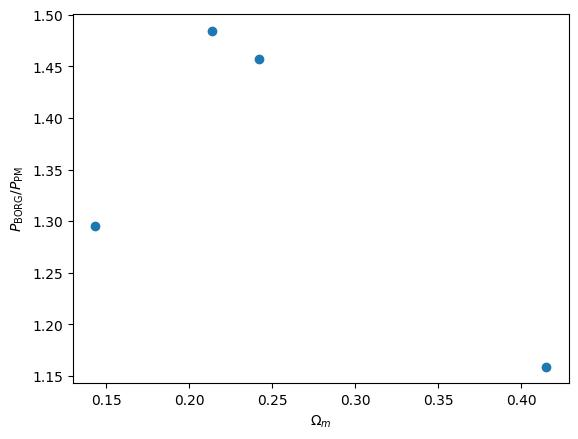

In [103]:
rat = np.array(Psb)/np.array(Psp)
rat = rat[:,0]

cs = np.array(cs)

plt.plot(cs[:,0], rat, 'o')
plt.xlabel('$\Omega_m$')
plt.ylabel('$P_{\mathrm{BORG}}/P_{\mathrm{PM}}$')

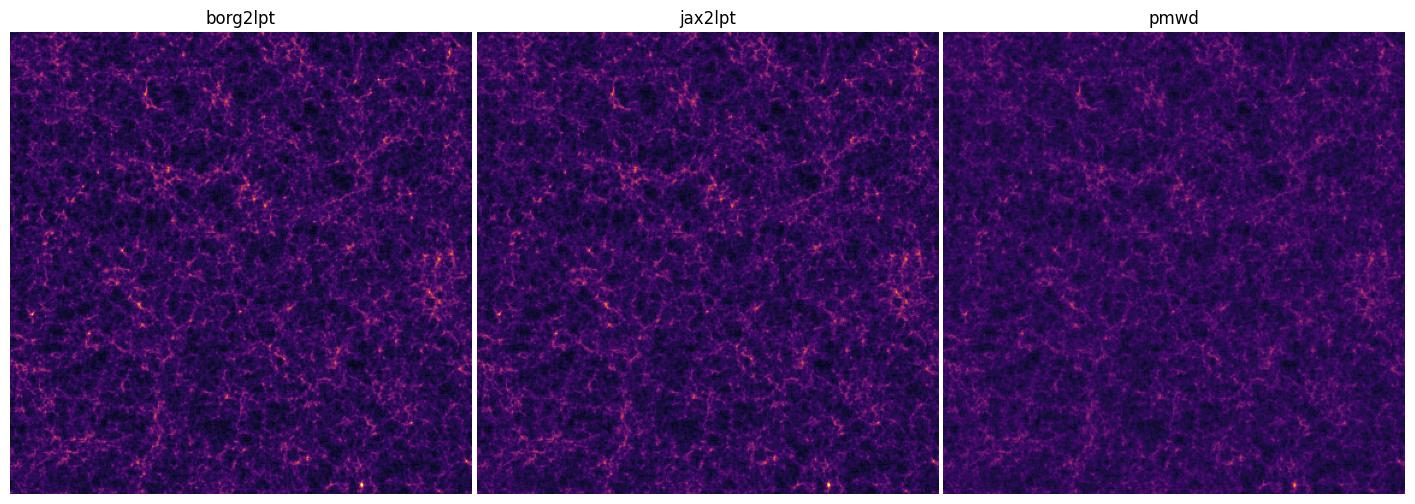

In [100]:
f, axs = plt.subplots(1,3, figsize=(18,10), gridspec_kw={'wspace':0.01})

for i, n in enumerate(['borg2lpt', 'jax2lpt', 'pmwd']):
    axs[i].imshow(np.mean(data[n]['rho'][50:60], axis=0), vmin=-1, vmax=5, cmap='inferno')
    axs[i].axis('off')
    axs[i].set_title(n)

# f.savefig('images/simcompare.jpg', dpi=200, bbox_inches='tight')

In [97]:
for n in ['borg2lpt', 'jax2lpt', 'pmwd']:
    print(np.max(data[n]['ppos']))

2999.999997817186
2999.99995679831
2999.9999175071716


borg2lpt
jax2lpt
pmwd


Text(0, 0.5, 'P(k)')

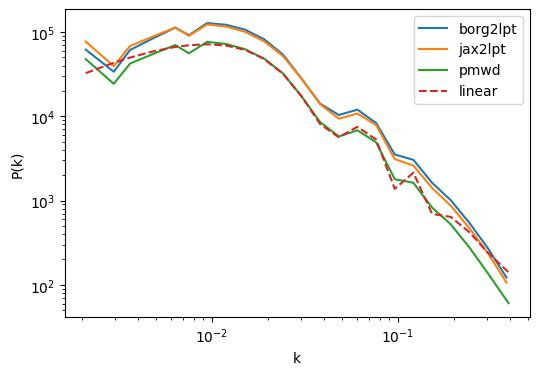

In [101]:
f, ax = plt.subplots(1,1, figsize=(6,4))

ax.loglog()
Ps = []
for i, n in enumerate(['borg2lpt', 'jax2lpt', 'pmwd']):
    print(n)
    dens = data[n]['rho']
    k, P, _, _ = powspec(dens, pmconf.cell_size)
    ax.plot(k, P, label=n)
    Ps.append(P)

Plin = linear_power(k, pmconf.a_stop, pmcosmo, pmconf)
ax.plot(k, Plin, ls='--', label='linear')
plt.legend()
plt.xlabel('k')
plt.ylabel('P(k)')

In [41]:
# (Ps[0]/Ps[2])-1
np.sqrt(1.28), np.sqrt(1.26)
pmconf.lpt_order

2

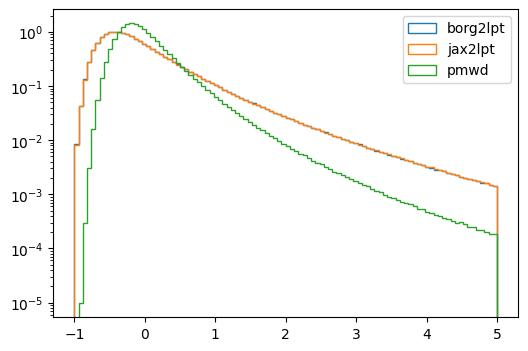

In [40]:
# plot the histogram of rho
f, ax = plt.subplots(1,1, figsize=(6,4))
ax.semilogy()
for i, n in enumerate(['borg2lpt', 'jax2lpt', 'pmwd']):
    rho = data[n]['rho']
    if n == 'pmwd':
        rho = (1+rho)-1
    ax.hist(rho.flatten(), bins=100, range=(-1,5), histtype='step', label=n, density=True)
ax.legend()

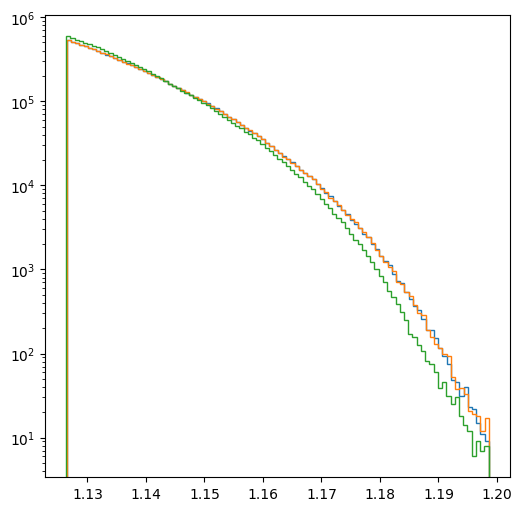

In [8]:
f, ax = plt.subplots(1,1, figsize=(6,6))

ax.semilogy()
for i, n in enumerate(['borg2lpt', 'jax2lpt', 'pmwd']):
    ax.hist(np.log10(data[n]['halo_mass']), bins=100, histtype='step', label=n)

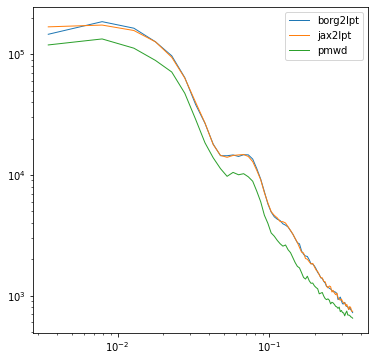

In [39]:
f, ax = plt.subplots(1,1, figsize=(6,6))
plt.loglog()

for i, n in enumerate(['borg2lpt', 'jax2lpt', 'pmwd']):
    j=0
    k, p0k, p2k, p4k = data[n]['Pk'][j]['k_gal'], data[n]['Pk'][j]['p0k_gal'], data[n]['Pk'][j]['p2k_gal'], data[n]['Pk'][j]['p4k_gal']
    ax.plot(k, p0k, lw=1, alpha=1, label=n)
    # ax.plot(k, p2k, lw=1, alpha=0.5)
    # ax.plot(k, p4k, lw=1, alpha=0.5)
ax.legend()

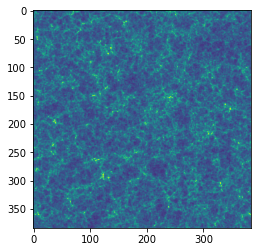

In [5]:
out = np.mean(r2[:20], axis=0)
plt.imshow(out, vmin=-1, vmax=2)

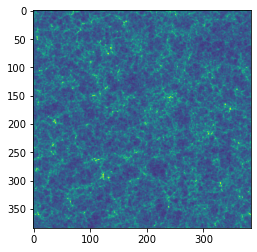

In [6]:
out = np.mean(r3[:20], axis=0)
plt.imshow(out, vmin=-1, vmax=2)

Text(0.5, 1.0, 'jax-2LPT')

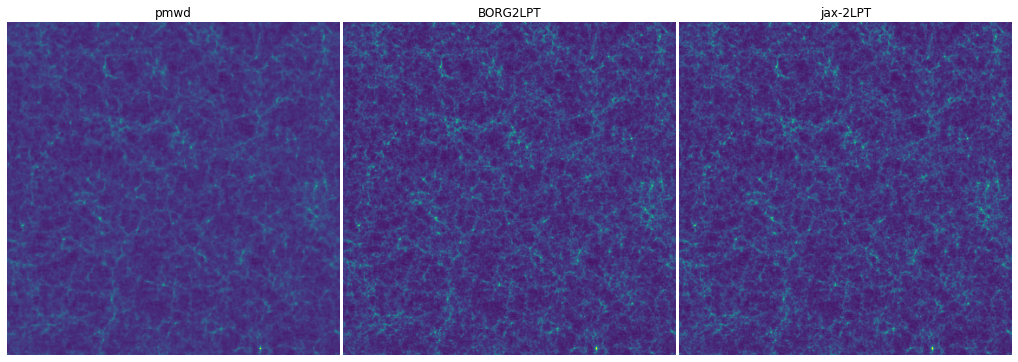

In [7]:
f, axs = plt.subplots(1,3, figsize=(18,10), gridspec_kw={'wspace':0.01})

axs[0].imshow(np.mean(r1[50:60], axis=0), vmin=-1, vmax=5)
axs[0].axis('off')
axs[0].set_title('pmwd')

axs[1].imshow(np.mean(r2[50:60], axis=0), vmin=-1, vmax=5)
axs[1].axis('off')
axs[1].set_title('BORG2LPT')

axs[2].imshow(np.mean(r3[50:60], axis=0), vmin=-1, vmax=5)
axs[2].axis('off')
axs[2].set_title('jax-2LPT')

# f.savefig('images/simcompare.jpg', dpi=200, bbox_inches='tight')

(-1.0, 10.0)

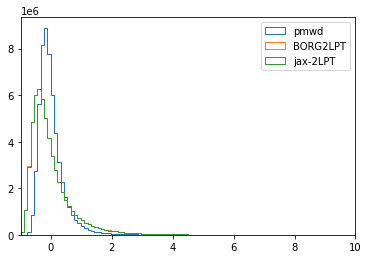

In [14]:
_ = plt.hist(r1.flatten(), bins=100, range=(-1,10), histtype='step', label='pmwd')
_ = plt.hist(r2.flatten(), bins=100, range=(-1,10), histtype='step', label='BORG2LPT')
_ = plt.hist(r3.flatten(), bins=100, range=(-1,10), histtype='step', label='jax-2LPT')
plt.legend()

plt.xlim(-1,10)

In [51]:
t.shape

(384, 384, 384)

In [49]:
from pmwd import (
    Configuration,
    Cosmology,
    boltzmann,
    linear_modes,
    lpt,
    nbody,
    scatter,
    white_noise
)

In [52]:
seed = 5
modes = white_noise(seed, pmconf)
# modes = linear_modes(modes, cosmo, pmconf)

In [65]:
N = 384
ic1 = np.fft.rfftn(np.random.randn(N, N, N)) / N ** (1.5)

In [71]:
N = 384
ic2 = np.fft.rfftn(np.random.randn(N, N, N))

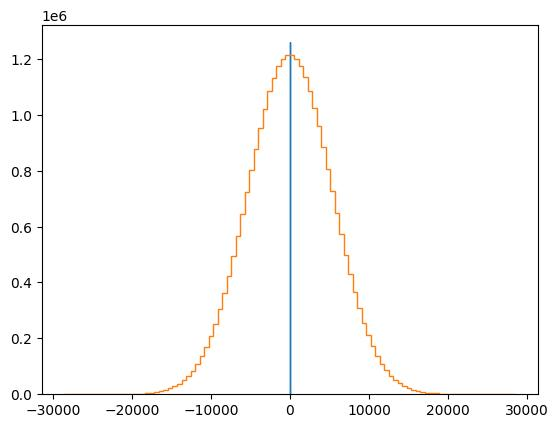

In [74]:
_ = plt.hist(ic1.real.flatten(), bins=100, histtype='step')
_ = plt.hist(ic2.real.flatten(), bins=100, histtype='step')